In [1]:
# === 02ByDealValuation breakdown by entry xEBITDA (terciles) ===
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

# ---- paths ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
OUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "02ByDealValuation")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV    = OUT_DIR / "deal_valuation.csv"

# ---- load + guards ----
df = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})
assert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."



# ---- build entry xEBITDA per deal ----
num = lambda s: pd.to_numeric(s, errors="coerce")

# rank within deal: 1 = entry (earliest reference_date)
df["_rank"] = df.groupby("deal_id")["reference_date"].transform(
    lambda s: pd.to_datetime(s, errors="coerce")
).groupby(df["deal_id"]).rank(method="first", ascending=True)

entry = (
    df.loc[df["_rank"] == 1, ["deal_id", "xebitda"]]
      .assign(entry_xebitda=num(df.loc[df["_rank"] == 1, "xebitda"]).values)
      .drop(columns=["xebitda"])
)

# drop deals with missing entry xEBITDA (cannot be bucketed)
entry_clean = entry.dropna(subset=["entry_xebitda"]).copy()

# ---- deterministic ordering to handle ties ----
entry_clean = entry_clean.sort_values(["entry_xebitda", "deal_id"], ascending=[True, True]).reset_index(drop=True)

# ---- assign terciles with near-equal counts (rank-based) ----
n = len(entry_clean)
if n == 0:
    raise ValueError("No deals with valid entry_xebitda to bucket.")

base, rem = divmod(n, 3)
sizes = [base, base, base]
for i in range(rem):              # distribute remainder to the highest terciles (High, then Mid)
    sizes[2 - i] += 1

# naming change only
labels = np.array(
    ["Low"] * sizes[0] +
    ["Mid"] * sizes[1] +
    ["High"] * sizes[2]
)
entry_clean["tercile"] = labels

# ---- attach tercile to all rows of each deal ----
bucket_map  = entry_clean.set_index("deal_id")["tercile"].to_dict()
xebitda_map = entry_clean.set_index("deal_id")["entry_xebitda"].to_dict()

out = df.copy()
out["entry_xebitda"]    = out["deal_id"].map(xebitda_map)
out["valuation_bucket"] = out["deal_id"].map(bucket_map)

# persist
out.to_csv(OUT_CSV, index=False)


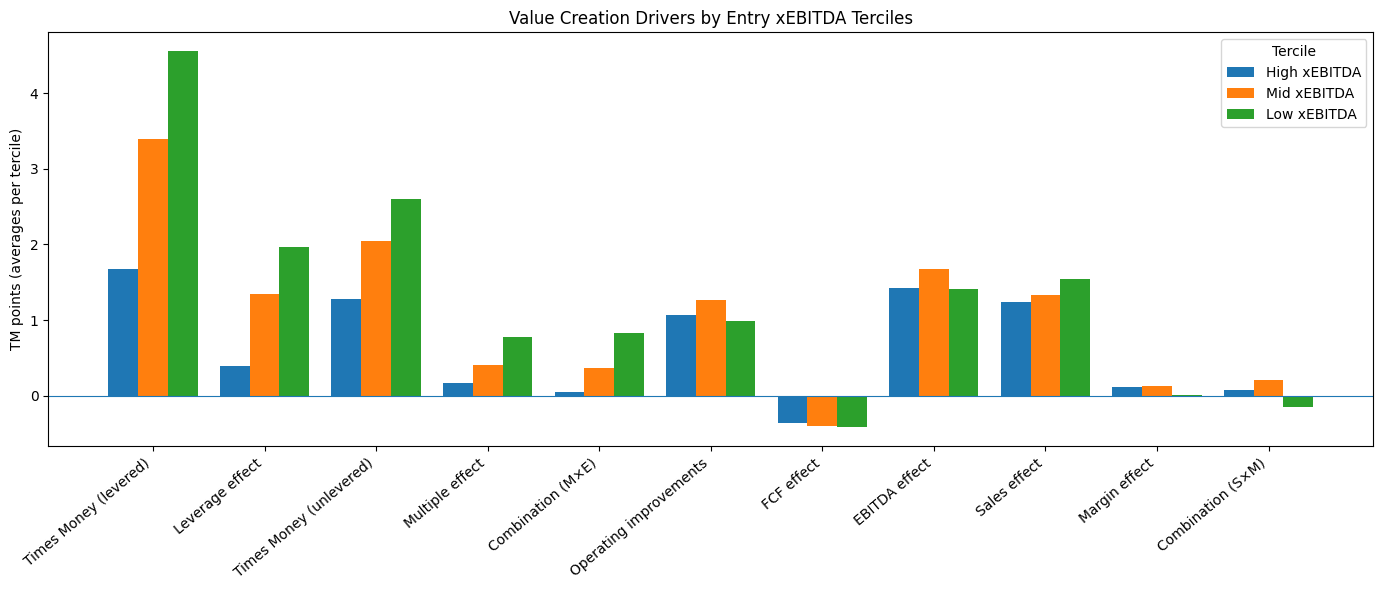

Deal counts per tercile: {'High': 115, 'Mid': 115, 'Low': 114}

TM-point averages per component × tercile:
valuation_bucket          High    Mid    Low
Times Money (levered)    1.678  3.388  4.557
Leverage effect          0.399  1.343  1.961
Times Money (unlevered)  1.279  2.046  2.596
Multiple effect          0.167  0.403  0.773
Combination (M×E)        0.048  0.373  0.832
Operating improvements   1.064  1.270  0.991
FCF effect              -0.361 -0.401 -0.419
EBITDA effect            1.426  1.671  1.410
Sales effect             1.237  1.331  1.539
Margin effect            0.111  0.127  0.014
Combination (S×M)        0.078  0.213 -0.143
{'panelB_eps': 0.001, 'dropped_near_zero_TM_per_bucket': {'High': 0, 'Mid': 0, 'Low': 0}, 'sum_TM_of_kept_deals_per_bucket': {'High': 192.97764320011444, 'Mid': 389.66953758496675, 'Low': 519.4426796411173}}


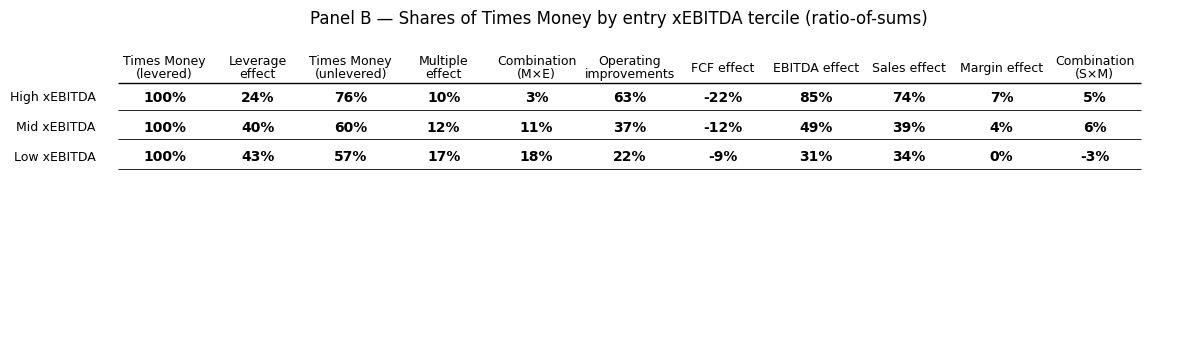

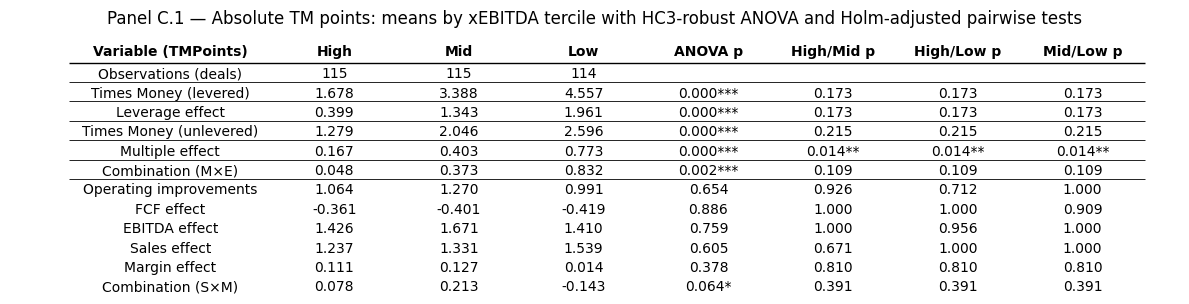

NameError: name 'SH' is not defined

In [2]:
# === Tercile Bridge — Clustered Bars per entry xEBITDA bucket ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------- paths ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

BASE       = find_upwards(Path("ValueCreation"))
WORK_CSV   = (BASE / "Data" / "working.csv")
BUCKET_CSV = (BASE / "ValueCreationBreakdown" / "02ByDealValuation" / "deal_valuation.csv")

# ---------- load ----------
work   = pd.read_csv(WORK_CSV, dtype={"deal_id": str})
bucket = pd.read_csv(BUCKET_CSV, dtype={"deal_id": str})

# ---------- deal-view (1 row per deal) + join terciles ----------
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
need = ["deal_id","valuation_bucket"] + NUMERIC_COLS

# After reading `work`
for c in NUMERIC_COLS:
    work[c] = pd.to_numeric(work[c], errors="coerce")

# Ensure both rows per deal have identical values for deal-level metrics
chk = work.groupby("deal_id")[NUMERIC_COLS].nunique(dropna=False)
bad = chk[(chk > 1).any(axis=1)]
assert bad.empty, f"Deal-level metrics vary within deal for {len(bad)} deals."

# collapse metrics per deal (take first by construction)
deal_metrics = work.groupby("deal_id", as_index=False)[NUMERIC_COLS].first()
deal_buckets = bucket.groupby("deal_id", as_index=False)[["valuation_bucket"]].first()
deal = deal_metrics.merge(deal_buckets, on="deal_id", how="left")[need]

# keep only labeled terciles (new names)
deal = deal[deal["valuation_bucket"].isin(["High","Mid","Low"])].copy()

# ---------- per-bucket means (TM points) ----------
grp = deal.groupby("valuation_bucket")

means = pd.DataFrame({
    "Times Money (levered)"  : grp["times_money"].mean(),
    "Leverage effect"        : grp["leverage_effect"].mean(),
    "Times Money (unlevered)": grp["tm_unlevered"].mean(),
    "Multiple effect"        : grp["tmu_contrib_multiple_effect"].mean(),
    "Combination (M×E)"      : grp["tmu_contrib_multiple_ebitda_combination_effect"].mean(),
    # Operating improvements on TMU scale = FCF + EBITDA
    "Operating improvements" : grp["tmu_contrib_fcf_effect"].mean() + grp["tmu_contrib_ebitda_effect"].mean(),
    "FCF effect"             : grp["tmu_contrib_fcf_effect"].mean(),
    "EBITDA effect"          : grp["tmu_contrib_ebitda_effect"].mean(),
    "Sales effect"           : grp["tmu_contrib_sales_effect"].mean(),
    "Margin effect"          : grp["tmu_contrib_margin_effect"].mean(),
    "Combination (S×M)"      : grp["tmu_contrib_sales_margin_combination_effect"].mean(),
}).T  # rows = components, cols = buckets

# enforce desired bucket order (columns) and component order (rows)
bucket_order = ["High","Mid","Low"]  # mirrors previous display order (top, mid, bottom)
means = means.reindex(columns=bucket_order)

component_order = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]
means = means.reindex(component_order)

# ---------- plot: clustered bars (one component group, 3 bars = terciles) ----------
fig, ax = plt.subplots(figsize=(14, 6))

n_comp   = len(means.index)
n_bucket = len(means.columns)
x        = np.arange(n_comp)
width    = 0.8 / n_bucket

for i, b in enumerate(means.columns):
    ax.bar(x + (i - (n_bucket-1)/2) * width, means[b].to_numpy(),
           width=width, label=f"{b} xEBITDA")

ax.set_xticks(x)
ax.set_xticklabels(means.index, rotation=40, ha="right")
ax.axhline(0, linewidth=0.8)
ax.set_ylabel("TM points (averages per tercile)")
ax.set_title("Value Creation Drivers by Entry xEBITDA Terciles")
ax.legend(title="Tercile")

fig.tight_layout()
plt.show()

# ---------- print & persist table of averages ----------
counts = deal.groupby("valuation_bucket")["deal_id"].nunique().reindex(bucket_order)
print("Deal counts per tercile:", counts.to_dict())

print("\nTM-point averages per component × tercile:")
print(means.round(3).to_string(float_format=lambda x: f"{x:.3f}"))

# === Panel B — table-style visualization (shares of Times Money) by xEBITDA tercile ===

# --- ratio-of-sums per tercile (shares in %) ---
cols_needed = [
    "times_money","leverage_effect",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
eps = 1e-3
grp = deal.groupby("valuation_bucket")
S = grp[cols_needed].sum().reindex(bucket_order).astype(float)

dropped_share = {}
kept_tm_sum   = {}
for b in bucket_order:
    tm_b = pd.to_numeric(deal.loc[deal["valuation_bucket"]==b, "times_money"], errors="coerce")
    dropped_share[b] = int((tm_b.abs() <= eps).sum())
    kept_tm_sum[b]   = float(tm_b[tm_b.abs() > eps].sum())

print({"panelB_eps": eps,
       "dropped_near_zero_TM_per_bucket": dropped_share,
       "sum_TM_of_kept_deals_per_bucket": kept_tm_sum})

den = S["times_money"].astype(float)
assert np.all(np.abs(den.values) > eps), "Zero total Times Money in at least one tercile."

def pct(col): return (S[col] / den) * 100.0

panelB = pd.DataFrame(index=bucket_order, columns=component_order, dtype=float)
panelB.loc[:, "Times Money (levered)"]   = 100.0
panelB.loc[:, "Leverage effect"]         = pct("leverage_effect")
panelB.loc[:, "Multiple effect"]         = pct("tmu_contrib_multiple_effect")
panelB.loc[:, "Combination (M×E)"]       = pct("tmu_contrib_multiple_ebitda_combination_effect")
panelB.loc[:, "FCF effect"]              = pct("tmu_contrib_fcf_effect")
panelB.loc[:, "EBITDA effect"]           = pct("tmu_contrib_ebitda_effect")
panelB.loc[:, "Sales effect"]            = pct("tmu_contrib_sales_effect")
panelB.loc[:, "Margin effect"]           = pct("tmu_contrib_margin_effect")
panelB.loc[:, "Combination (S×M)"]       = pct("tmu_contrib_sales_margin_combination_effect")
panelB.loc[:, "Operating improvements"]  = panelB["FCF effect"] + panelB["EBITDA effect"]
panelB.loc[:, "Times Money (unlevered)"] = (
    panelB["Multiple effect"] + panelB["Combination (M×E)"] + panelB["Operating improvements"]
)

# --- table-like figure with headers and three value rows (High/Mid/Low) ---
headers = component_order
rows    = bucket_order

n_cols = len(headers)
n_rows = len(rows)
fig_h  = 3.0 + (n_rows-1) * 0.25
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

y_header = 0.88 #0.88
row_start = 0.78 #0.66
row_gap   = 0.1 #0.16
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 14
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(hdr, width=wrap_w),
            ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
row_names = {"High": "High xEBITDA", "Mid": "Mid xEBITDA", "Low": "Low xEBITDA"}
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, row_names[r],
            ha="right", va="center", fontsize=9, transform=ax.transAxes)

for y_pos, r in zip(ys, rows):
    for x_pos, hdr in zip(xs, headers):
        val = panelB.loc[r, hdr]
        ax.text(x_pos, y_pos, f"{val:.0f}%", ha="center", va="center",
                fontsize=10, fontweight="bold", transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

ax.set_title("Panel B — Shares of Times Money by entry xEBITDA tercile (ratio-of-sums)", pad=6)
fig.tight_layout()
plt.show()


# === Panel C — Significance tables (HC3-robust OLS + two-sided pairwise with Holm) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import textwrap
import statsmodels.formula.api as smf

# ---- helpers ----
def p_to_stars(p):
    if p is None or np.isnan(p): return ""
    if p < 0.01:  return "***"
    if p < 0.05:  return "**"
    if p < 0.10:  return "*"
    return ""

def fmt_p(p):
    if p is None or np.isnan(p): return "n/a"
    return f"{p:.3f}{p_to_stars(p)}"

def holm_adjust(pvals):
    p = np.asarray(pvals, float)
    # Handle NaN gracefully: keep NaNs as NaN, adjust only finite p's
    finite_mask = np.isfinite(p)
    adj = np.array(p, copy=True)
    if finite_mask.sum() <= 1:
        return adj
    idx = np.where(finite_mask)[0]
    pf = p[finite_mask]
    order = np.argsort(pf)
    m = len(pf)
    adjf = np.empty_like(pf)
    for k, j in enumerate(order):
        adjf[j] = min(1.0, (m - k) * pf[j])
    # enforce monotonicity
    for k in range(m - 2, -1, -1):
        adjf[order[k]] = max(adjf[order[k]], adjf[order[k + 1]])
    adj[finite_mask] = adjf
    return adj

def table_figure(headers, rows, cell_text, title, wrap_w=16,
                 left_margin=0.05, right_margin=0.97,
                 row_gap=0.12, header_y=0.88, start_y=0.74,
                 fontsize_hdr=10, fontsize_val=10):
    n_cols = len(headers)
    n_rows = len(rows)
    fig_h  = 2.8 + max(0, (n_rows-1)) * (row_gap*0.9)
    fig, ax = plt.subplots(figsize=(12, fig_h))
    ax.set_axis_off()

    # column centers with a wider first column
    def column_centers(n_cols, left_margin=0.05, right_margin=0.97,
                       first_ratio=1.55, other_ratio=0.95):
        total = right_margin - left_margin
        ratios = np.array([first_ratio] + [other_ratio] * (n_cols - 1), dtype=float)
        widths = total * ratios / ratios.sum()
        xs = left_margin + np.cumsum(np.r_[0, widths[:-1]]) + widths / 2.0
        return xs, widths

    xs, col_widths = column_centers(n_cols, left_margin=left_margin, right_margin=right_margin)
    ys = [start_y - i*row_gap for i in range(n_rows)]

    # headers (bold)
    wrap_w_hdr = [20] + [13] * (n_cols - 1)
    for j, (x_pos, hdr) in enumerate(zip(xs, headers)):
        ww = wrap_w_hdr[j] if j < len(wrap_w_hdr) else 14
        ax.text(x_pos, header_y, textwrap.fill(hdr, width=ww),
                ha="center", va="center", fontsize=fontsize_hdr, linespacing=1.05,
                transform=ax.transAxes, fontweight="bold")

    # body cells
    for y, row_vals in zip(ys, cell_text):
        for x, val in zip(xs, row_vals):
            ax.text(x, y, str(val), ha="center", va="center",
                    fontsize=fontsize_val, transform=ax.transAxes)

    # rules
    sep_top = (header_y + ys[0]) / 2
    ax.hlines([sep_top], xmin=left_margin, xmax=right_margin, colors="black", linewidth=1.0, transform=ax.transAxes)
    for y in ys:
        ax.hlines([y - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin, colors="black", linewidth=0.6, transform=ax.transAxes)

    ax.set_title(title, pad=6)
    fig.tight_layout()
    plt.show()

def _long_df_from_groups(arrH, arrM, arrL):
    """Build long form DataFrame for statsmodels."""
    return pd.DataFrame({
        "value": np.r_[arrH, arrM, arrL],
        "valuation_bucket": (["High"] * len(arrH)) + (["Mid"] * len(arrM)) + (["Low"] * len(arrL)),
    }).dropna(subset=["value", "valuation_bucket"])

def robust_overall_and_pairs(df_var):
    """
    HC3-robust OLS: value ~ C(valuation_bucket)
    Returns overall (Wald) p and pairwise two-sided p-values with Holm adjustment.
    """
    # Ensure fixed baseline ('Low') for clean contrasts
    dfv = df_var.copy()
    dfv["valuation_bucket"] = pd.Categorical(dfv["valuation_bucket"], categories=["Low","Mid","High"], ordered=True)

    m = smf.ols("value ~ C(valuation_bucket)", data=dfv).fit(cov_type="HC3")

    # Overall: H0 all means equal -> both dummy coefs == 0
    overall = m.f_test("C(valuation_bucket)[T.Mid] = C(valuation_bucket)[T.High] = 0")
    p_overall = float(overall.pvalue)

    # Pairwise contrasts (two-sided):
    # With 'Low' as base, parameters are [Intercept, C(...)[T.Mid], C(...)[T.High]]
    # High - Mid = beta_High - beta_Mid
    p_hm = float(m.t_test([0, -1.0, 1.0]).pvalue)
    # High - Low = beta_High
    p_hl = float(m.t_test([0,  0.0, 1.0]).pvalue)
    # Mid  - Low = beta_Mid
    p_ml = float(m.t_test([0,  1.0, 0.0]).pvalue)

    raw = np.array([p_hm, p_hl, p_ml])
    adj = holm_adjust(raw)
    pair_raw  = dict(zip(["High/Mid","High/Low","Mid/Low"], raw))
    pair_holm = dict(zip(["High/Mid","High/Low","Mid/Low"], adj))
    return p_overall, pair_raw, pair_holm

# ---- data per bucket (deal-level vectors) ----
bH, bM, bL = bucket_order  # ["High","Mid","Low"]
components = [
    ("Times Money (levered)",  "times_money"),
    ("Leverage effect",        "leverage_effect"),
    ("Times Money (unlevered)","tm_unlevered"),
    ("Multiple effect",        "tmu_contrib_multiple_effect"),
    ("Combination (M×E)",      "tmu_contrib_multiple_ebitda_combination_effect"),
    ("Operating improvements", None),  # FCF + EBITDA
    ("FCF effect",             "tmu_contrib_fcf_effect"),
    ("EBITDA effect",          "tmu_contrib_ebitda_effect"),
    ("Sales effect",           "tmu_contrib_sales_effect"),
    ("Margin effect",          "tmu_contrib_margin_effect"),
    ("Combination (S×M)",      "tmu_contrib_sales_margin_combination_effect"),
]

G = {b: deal.loc[deal["valuation_bucket"]==b].copy() for b in [bH,bM,bL]}
for b in [bH,bM,bL]:
    G[b]["_op_impr"] = G[b]["tmu_contrib_fcf_effect"] + G[b]["tmu_contrib_ebitda_effect"]

nH = int(G[bH]["deal_id"].nunique()); nM = int(G[bM]["deal_id"].nunique()); nL = int(G[bL]["deal_id"].nunique())

# ================= Panel C.1 — Absolute TM points =================
headers_C1 = ["Variable (TMPoints)", bH, bM, bL, "ANOVA p", f"{bH}/{bM} p", f"{bH}/{bL} p", f"{bM}/{bL} p"]
rows_C1    = ["Observations (deals)"] + [lbl for (lbl, _) in components]
cell_text_C1 = []
cell_text_C1.append(["Observations (deals)", f"{nH:.0f}", f"{nM:.0f}", f"{nL:.0f}", "", "", "", ""])

for label, col in components:
    if label == "Operating improvements":
        arrH = G[bH]["_op_impr"].to_numpy(); arrM = G[bM]["_op_impr"].to_numpy(); arrL = G[bL]["_op_impr"].to_numpy()
    else:
        arrH = G[bH][col].to_numpy();       arrM = G[bM][col].to_numpy();       arrL = G[bL][col].to_numpy()

    # means for display
    mH, mM, mL = float(np.nanmean(arrH)), float(np.nanmean(arrM)), float(np.nanmean(arrL))

    # stats (HC3 overall + two-sided pairwise with Holm)
    df_var = _long_df_from_groups(arrH, arrM, arrL)
    p_overall, pair_raw, pair_holm = robust_overall_and_pairs(df_var)

    cell_text_C1.append([
        label,
        f"{mH:.3f}", f"{mM:.3f}", f"{mL:.3f}",
        fmt_p(p_overall),  # overall (HC3)
        fmt_p(pair_holm["High/Mid"]),
        fmt_p(pair_holm["High/Low"]),
        fmt_p(pair_holm["Mid/Low"]),
    ])

table_figure(headers_C1, rows_C1, cell_text_C1,
             title="Panel C.1 — Absolute TM points: means by xEBITDA tercile with HC3-robust ANOVA and Holm-adjusted pairwise tests",
             wrap_w=18, row_gap=0.12, header_y=0.88, start_y=0.74)

# ================= Panel C.2 — Shares of Times Money (% of TM) =================
# build per-deal share vectors (you already built SH[...] above)
share_rows_order = [
    "Times Money (unlevered) (%)",
    "Leverage effect (%)",
    "Multiple effect (%)",
    "Combination (M×E) (%)",
    "Operating improvements (%)",
    "FCF effect (%)",
    "EBITDA effect (%)",
    "Sales effect (%)",
    "Margin effect (%)",
    "Combination (S×M) (%)",
]

headers_C2 = ["Variable (% of TM)", bH, bM, bL, "ANOVA p", f"{bH}/{bM} p", f"{bH}/{bL} p", f"{bM}/{bL} p"]
rows_C2    = ["Observations (deals)"] + share_rows_order
cell_text_C2 = []

nH_share = len(SH[bH]["Leverage effect (%)"])
nM_share = len(SH[bM]["Leverage effect (%)"])
nL_share = len(SH[bL]["Leverage effect (%)"])
cell_text_C2.append(["Observations (deals)", f"{nH_share:.0f}", f"{nM_share:.0f}", f"{nL_share:.0f}", "", "", "", ""])

for label in share_rows_order:
    arrH, arrM, arrL = SH[bH][label], SH[bM][label], SH[bL][label]
    mH = float(np.nanmean(arrH)) if len(arrH) else np.nan
    mM = float(np.nanmean(arrM)) if len(arrM) else np.nan
    mL = float(np.nanmean(arrL)) if len(arrL) else np.nan

    df_var = _long_df_from_groups(arrH, arrM, arrL)
    p_overall, pair_raw, pair_holm = robust_overall_and_pairs(df_var)

    cell_text_C2.append([
        label,
        f"{mH:.1f}" if mH==mH else "—",
        f"{mM:.1f}" if mM==mM else "—",
        f"{mL:.1f}" if mL==mL else "—",
        fmt_p(p_overall),
        fmt_p(pair_holm["High/Mid"]),
        fmt_p(pair_holm["High/Low"]),
        fmt_p(pair_holm["Mid/Low"]),
    ])

table_figure(headers_C2, rows_C2, cell_text_C2,
             title="Panel C.2 — Shares of Times Money: means by xEBITDA tercile with HC3-robust ANOVA and Holm-adjusted pairwise tests",
             wrap_w=22, row_gap=0.12, header_y=0.88, start_y=0.74)
